Authors: Nicolas Legrand <nicolas.legrand@cfin.au.dk>

In [145]:
import os
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mne.io import read_raw_brainvision
from scipy.signal import welch
from scipy.signal import hilbert
from scipy.signal import find_peaks

from gastropy.plots import plot_raw 

from bokeh.layouts import column
from bokeh.models import ColumnDataSource, RangeTool
from bokeh.plotting import figure
from bokeh.io import show
from bokeh.io import output_notebook, show

output_notebook()
%matplotlib inline

Loading BokehJS ...

In [146]:
new_sfreq = 5  # Downsample signal
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sub = 'sub_0025'

# EGG summary results

## Load data and extract events

In [147]:
# Load raw data
data = read_raw_brainvision(path + f'/VMP_01_{sub[4:]}.vhdr', preload=True)
# Read events file
events, events_id = mne.events_from_annotations(data)

Extracting parameters from C:\Users\au646069\ECG/VMP_01_0025.vhdr...
Setting channel info structure...
Reading 0 ... 4809359  =      0.000 ...  4809.359 secs...
Used Annotations descriptions: ['New Segment/', 'Response/R128', 'Stimulus/S  1', 'Stimulus/S128', 'SyncStatus/Sync On']


## Select Resting state

In [148]:
lenSignal = events[-1, 0]

stimChannel = np.array([0 if (events[i, 2] == 99998) & (events[i+1, 2] == 99998) else 1 for i in range(len(events)-1)])
stimChannel = np.append(stimChannel, 0)
stimChannel[0] = 0

restStart, restStop = np.where(np.diff(stimChannel))[0][:2]

tStart, tEnd = events[restStart, 0]/1000, events[restStop, 0]/1000

## Preprocessing

In [149]:
# Apply low-pass filter (2 Hz)
data = data.filter(h_freq=2, l_freq=None)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 2.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Filter length: 1651 samples (1.651 sec)



In [150]:
# Resample raw data
data = data.resample(new_sfreq)

In [151]:
preprocessed_df = data.to_data_frame(long_format=False, index='time').reset_index()
preprocessed_df['time'] = np.arange(0, len(preprocessed_df)) / (new_sfreq)
preprocessed_df = preprocessed_df[(preprocessed_df['time']>tStart) & (preprocessed_df['time']<tEnd)]

In [152]:
preprocessed_df.head()

channel,time,EGG1,EGG2,EGG3,EGG4,EGG5,EGG6,RESP,PLETH
542,108.4,-292.725983,-1403.725127,2694.487420,997.402040,-326.629469,-108.028556,2.474433e+06,828430.236548
543,108.6,-286.987768,-1426.417633,2623.724361,960.377912,-326.750385,-104.801582,2.474382e+06,535010.286108
544,108.8,-319.590379,-1539.682093,2623.639055,898.099191,-324.614425,-112.395737,2.474368e+06,360405.467700
545,109.0,-317.164574,-1624.640444,2632.460839,864.331807,-341.072524,-114.849440,2.474339e+06,117641.325099
546,109.2,-442.836315,-1639.389066,2551.345598,820.994819,-330.854454,-91.305650,2.474386e+06,765789.293213


# Raw plot

In [163]:
signal1 = preprocessed_df.EGG1.to_numpy()
signal2 = preprocessed_df.EGG2.to_numpy()
signal3 = preprocessed_df.EGG3.to_numpy()
signal4 = preprocessed_df.EGG4.to_numpy()
signal5 = preprocessed_df.EGG5.to_numpy()
signal6 = preprocessed_df.EGG6.to_numpy()

In [165]:
show(
    plot_raw(signal=[signal1, signal2, signal3, signal4, signal5, signal6])
)

# PSD

In order to increase frequency resolution (smooth curve), `nfft` should be high (~ 5 * nperseg). The resulting frequency resolution may also **vary depending on the initial signal lenght**.

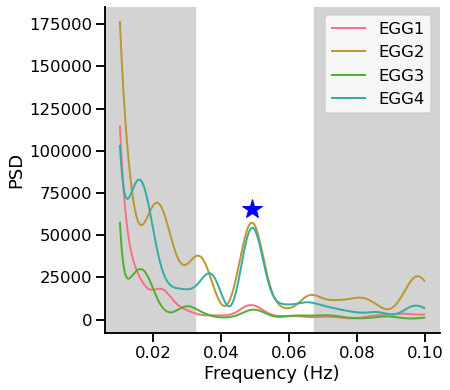

In [47]:
keepChannel = [0, 0, '']

# Range of frequencies to plot
freq_range = [0.01, .1]
    
# Range of frequencies to highlight
freq_band = [0.033, 0.067]

fig, axs = plt.subplots(figsize=(6, 6))
sns.set_context("talk")
sns.set_palette("husl")
axs.set_facecolor('lightgrey')

# Frequency band of interest
axs.axvspan(freq_band[0], freq_band[-1], color='w')

for ch in ['EGG1', 'EGG2', 'EGG3', 'EGG4']:
    
    signal = preprocessed_df[ch].to_numpy()
    # Estimate PSD of given signal
    freqs, psd = welch(x=signal, fs=new_sfreq, nperseg=1000, nfft=20000)

    freqs_ = freqs[(freqs > freq_range[0]) & (freqs < freq_range[1])]
    psd_ = psd[(freqs > freq_range[0]) & (freqs < freq_range[1])]

    # Plot PSD between 0.01 and 0.1 Hz
    plt.plot(freqs_, psd_, linewidth=2, label=ch)

    freqsBand_ = freqs_[(freqs_ > freq_band[0]) & (freqs_ < freq_band[1])]
    psdBand_ = psd_[(freqs_ > freq_band[0]) & (freqs_ < freq_band[1])]
    
    # Find peak frequency
    freq_peak = freqsBand_[find_peaks(psdBand_)[0]]
    psd_peak = psdBand_[find_peaks(psdBand_)[0]]

    if not psd_peak.shape[0] == 0:
        for p, f in zip(psd_peak, freq_peak):
            if p > keepChannel[1]:
                keepChannel = [f, p, ch]
        
# Show peak frequency
plt.plot(keepChannel[0],
         keepChannel[1]+20**3,
         marker='*', color='b', markersize=20)
plt.legend()
plt.ylabel('PSD')
plt.xlabel('Frequency (Hz)')
sns.despine()

# Bandpass filter

In [49]:
data = read_raw_brainvision(path + f'/VMP_01_{sub[4:]}.vhdr', preload=True)

# bandpass filter
interval = 0.015
data.filter(keepChannel[0]-interval, keepChannel[0]+interval,
            l_trans_bandwidth=0.015,  # make sure filter params are the same
            h_trans_bandwidth=0.015, verbose=False)  # in each band and skip "auto" option.

# Resample raw data
data = data.resample(new_sfreq)
filtered_df = data.to_data_frame(long_format=False, index='time').reset_index()
filtered_df['time'] = np.arange(0, len(filtered_df))/(new_sfreq)
filtered_df = filtered_df[(filtered_df['time']>tStart) & (filtered_df['time']<tEnd)]

Extracting parameters from C:\Users\au646069\ECG/VMP_01_0025.vhdr...
Setting channel info structure...
Reading 0 ... 4809359  =      0.000 ...  4809.359 secs...


In [51]:
time = pd.to_datetime(
    filtered_df.time.to_numpy() - filtered_df.time.to_numpy()[0], unit="s", origin="unix"
)

source = ColumnDataSource(
    data={"time": time,
          "EGG": filtered_df[keepChannel[-1]],
         }
)
    
raw = figure(
        title="Raw data",
        x_axis_type="datetime",
        sizing_mode="stretch_width",
        plot_height=400,
        x_axis_label="Time",
        y_axis_label="EGG",
        output_backend="webgl",
        x_range=(time[0], time[-1]),
    )

raw.line("time", "EGG", source=source)

select = figure(title="Drag the middle and edges of the selection box to change the range above",
                plot_height=130, plot_width=800, y_range=raw.y_range,
                x_axis_type="datetime", y_axis_type=None,
                tools="", toolbar_location=None, background_fill_color="#efefef")

range_tool = RangeTool(x_range=raw.x_range)
range_tool.overlay.fill_color = "navy"
range_tool.overlay.fill_alpha = 0.2

select.line('time', 'EGG', source=source)
select.ygrid.grid_line_color = None
select.add_tools(range_tool)
select.toolbar.active_multi = range_tool

show(column(raw, select))

# Hilbert transform

In [52]:
analytic_signal = hilbert(filtered_df[keepChannel[-1]], )
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase)/(2.0*np.pi) * 10)

phase = np.angle(analytic_signal)
peaks = find_peaks(phase, height=2)[0]

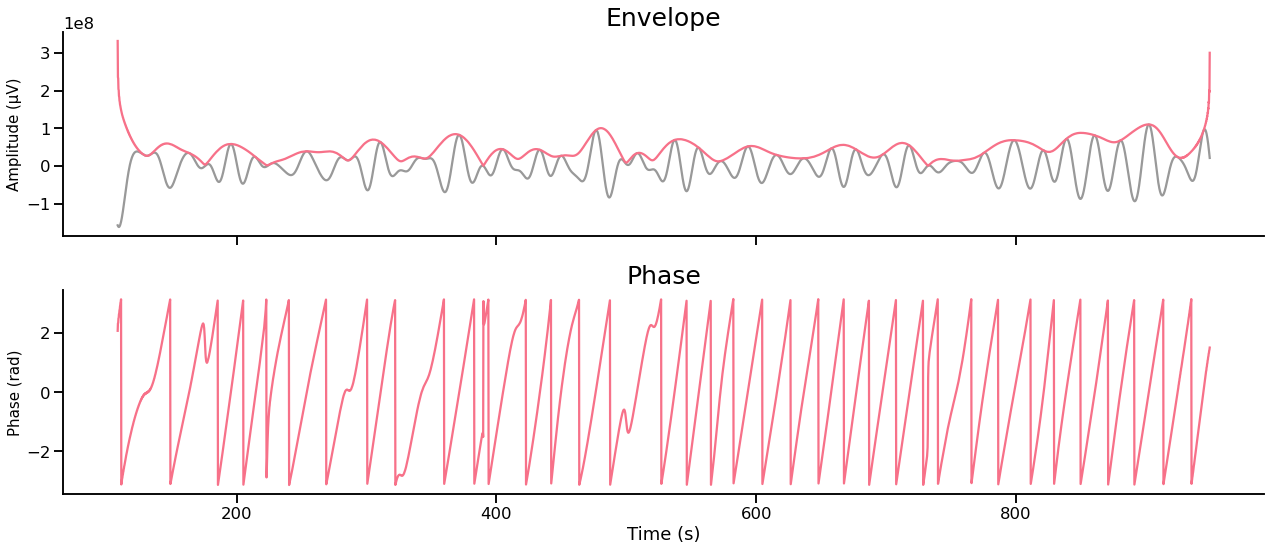

In [53]:
fig, axs = plt.subplots(figsize=(18, 8), sharex=True, nrows=2)
axs[0].plot(filtered_df.time, filtered_df[keepChannel[-1]] * 1000000, label='signal', alpha=.4, color='k')
axs[0].plot(filtered_df.time, amplitude_envelope * 1000000, label='envelope')
axs[0].set_title('Envelope', size=25)
axs[0].set_ylabel('Amplitude (µV)', size=15)
#ax0.set_xlim(100, 700)
#ax0.set_ylim(-150, 150)

#axs[1].plot(peaks, phase[peaks], 'ro')
axs[1].plot(filtered_df.time, phase)
axs[1].set_xlabel("Time (s)")
axs[1].set_title('Phase', size=25)
axs[1].set_ylabel('Phase (rad)', size=15)
#ax1.set_ylim(-6, 6)
#ax1.set_xlim(100, 700)

plt.tight_layout()
sns.despine()

## Cycles variability

Find cycles lengths

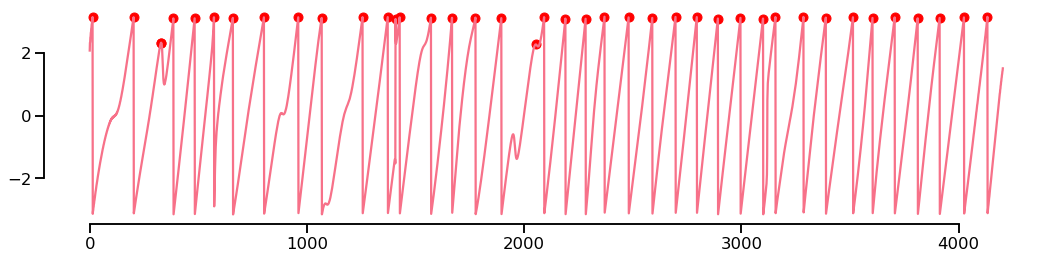

In [54]:
plt.figure(figsize=(18, 4))
plt.plot(peaks, phase[peaks], 'ro')
plt.plot(phase)
sns.despine(trim=10)

## Distribution of cycles length

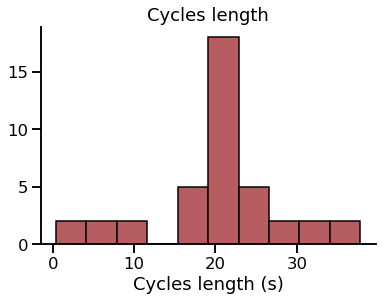

In [55]:
plt.hist(np.diff(peaks)/new_sfreq, color=['#b55d60'], ec="k", density=False, align='mid')
plt.title('Cycles length')
plt.xlabel('Cycles length (s)')
sns.despine()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """


Text(0.5, 0, 'Time (s)')

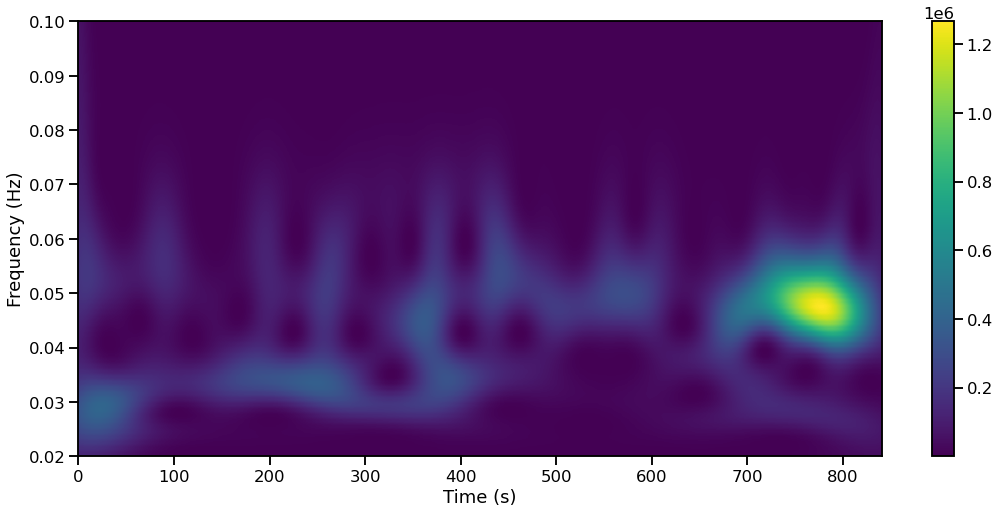

In [56]:
from mne.time_frequency import tfr_array_morlet

fig = plt.figure(figsize=(18, 8))

tfr = tfr_array_morlet(filtered_df[keepChannel[-1]][np.newaxis, np.newaxis, :], 
                            output='power', sfreq=new_sfreq, 
                            freqs=np.arange(0.02, .1, 0.001))[0, 0]
plt.imshow(tfr, aspect='auto', origin='lower', extent=[0, len(filtered_df)/new_sfreq, 0.02, .1])
plt.colorbar()
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')